# Clustering FakeNewsNet - PolitiFact content

___OBS:___ _The data examined in this notebook can be downloaded from [here](https://www.kaggle.com/datasets/mdepak/fakenewsnet?resource=download&select=PolitiFactUserFeature.mat)_

In [17]:
from pathlib import Path

import numpy as np
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
pd.options.future.infer_string = True

In [18]:
from itertools import product
from collections import defaultdict


# Inspiration from ChatGPT
def get_tuple_combinations(list1, list2):
    combinations = [(item1, item2) for item1, item2 in product(list1, list2) if item1 != item2 and item1 < item2]
    return combinations

In [19]:
# Set path to data folder
DATA_DIR = Path(r"C:\Users\alber\Desktop\DTU\3_HCAI\02807\project\02807_CompTools_Project\data")

## Load data

In [20]:
# Load social content data - i.e. user and news "interactions" 
newsId              = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFactNews.txt', sep='\t', header=None)
userId              = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFactUser.txt', sep='\t', header=None)

# Create index mappings
idx2newsId          = {i+1: key for i, key in enumerate(newsId[0])}
idx2userId          = {i+1: key for i, key in enumerate(userId[0])}

# Add real user and news ids/names to dataframe
NewsUser            = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFactNewsUser.txt', sep='\t', header=None).rename(columns={0: 'newsIndex', 1: 'userIndex', 2: 'n_shares'})
NewsUser['newsId']  = NewsUser['newsIndex'].map(idx2newsId) 
NewsUser['userId']  = NewsUser['userIndex'].map(idx2userId)

# Show resulting dataframe
print(NewsUser.shape)
NewsUser.head()

(32791, 5)


,newsIndex,userIndex,n_shares,newsId,userId
0,240,1,1,PolitiFact_Fake_120,f4b46be21c2f553811cc8a73c4f0ff05
1,124,2,1,PolitiFact_Fake_4,2ced3734cc9c164edd9a8f5fbebe976f
2,162,3,1,PolitiFact_Fake_42,c84c4ea8ba67211f84781bdd64cafe43
3,233,4,1,PolitiFact_Fake_113,1776d1765f5e82cd660d8d502f227402
4,50,5,1,PolitiFact_Real_50,4e8c2c300d96929895ce0edba915af16


In [21]:
# Load content of news data
fake_news       = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFact_fake_news_content.csv', engine="pyarrow")
real_news       = pd.read_csv(DATA_DIR / 'raw/FakeNewsNet/PolitiFact_real_news_content.csv', engine="pyarrow")
df              = pd.concat([real_news, fake_news]).reset_index(drop=True)
df['news_id']   = newsId
df.to_csv(DATA_DIR / 'processed/FakeNewsNet/PolitiFactNewsContent.csv', index=False)

df.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,news_id
0,Real_1-Webpage,Trump Just Insulted Millions Who Lost Everythi...,16.8k SHARES SHARE THIS STORY Hillary Clinton...,http://occupydemocrats.com/2016/09/27/trump-ju...,http://occupydemocrats.com/wp-content/uploads/...,"Brett Bose,Grant Stern,Steve Bernstein,Natalie...",http://occupydemocrats.com,{'$date': 1474934400000},NaN,http://occupydemocrats.com/wp-content/uploads/...,http://occupydemocrats.com/2016/09/27/trump-ju...,"{""generator"": ""Powered by Visual Composer - dr...",PolitiFact_Real_1
1,Real_10-Webpage,Famous dog killed in spot she waited a year fo...,Famous dog killed in spot she waited a year fo...,http://rightwingnews.com/top-news/famous-dog-k...,http://rightwingnews.com/wp-content/uploads/20...,NaN,http://rightwingnews.com,{'$date': 1474948336000},NaN,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/top-news/famous-dog-k...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",PolitiFact_Real_2
2,Real_100-Webpage,House oversight panel votes Clinton IT chief i...,Story highlights The House Oversight panel vot...,http://cnn.it/2deaH2d,http://i2.cdn.cnn.com/cnnnext/dam/assets/16091...,"Tom Lobianco,Deirdre Walsh",http://cnn.it,NaN,NaN,http://i2.cdn.cnn.com/cnnnext/dam/assets/17050...,http://www.cnn.com/2016/09/22/politics/bryan-p...,"{""description"": ""Members of the House Oversigh...",PolitiFact_Real_3
3,Real_101-Webpage,America Just Tragically Lost A Country Music I...,We are absolutely heartbroken to hear about th...,http://newsbake.com/entertainment-news/music-e...,http://newsbake.com/wp-content/uploads/2016/05...,Nancy Wells,http://newsbake.com,{'$date': 1474898600000},https://www.youtube.com/embed/8ozTJcu-_BU,http://0.gravatar.com/avatar/0d702c6042933cd78...,http://newsbake.com/entertainment-news/music-e...,"{""shareaholic"": {""site_name"": ""NewsBake"", ""lan...",PolitiFact_Real_4
4,Real_102-Webpage,Monuments to the Battle for the New South,"Nine years ago, a driver lost control of his p...",http://politi.co/2dd9U1x,http://static.politico.com/25/ed/85332de14c45b...,"Jack Shafer,Lisa Rab",http://politi.co,{'$date': 1473941820000},NaN,http://static.politico.com/25/ed/85332de14c45b...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""Virginia, increasingly divers...",PolitiFact_Real_5


In [22]:
np.random.seed(0)

# Determine test split size
test_size   = 0.2
newsIds     = list(newsId[0].unique())
N_total     = len(newsIds)
N_test      = int(test_size * N_total)

# Shuffle newsIds
newsIds     = np.random.permutation(newsIds)

# Split news into train and test
testIds     = newsIds[:N_test]
trainIds    = newsIds[N_test:]

assert np.intersect1d(testIds, trainIds).__len__() == 0

# Store test and train ids
with open(DATA_DIR / 'processed/FakeNewsNet/testIds.txt', 'w') as f:
    f.write('\n'.join(testIds))
with open(DATA_DIR / 'processed/FakeNewsNet/trainIds.txt', 'w') as f:
    f.write('\n'.join(trainIds))

## Constructing the FakeNewsNet-graph

We aim at representing the relation between news articles. As such, the final goal is to try to cluster news articles and evaluate these clusters compared to the ground truth _news/fake news_ labeling. For doing so, we construct a undirected graph with news articles as nodes and edges being defined by news article having at least two Twitter users that shares the article in common. Thus, the graph is constructed in the following steps:
1) Remove all singleton articles, i.e. find and remove all users that only shared one article
2) For all remaining users, find all tuple combinations of articles from the users sharing history (without self-loops)
3) Add weight to the edges by considering the amount of users that shared both the target and source node.
4) Build the undirected graph using `networkx`

In [23]:
# Find and remove all users that only shared one article
activeUsers         = np.sort(NewsUser['userIndex'].unique())[NewsUser.groupby('userIndex').size() > 1]
activeUsers_idxs    = NewsUser['userIndex'].progress_apply(lambda x: x in activeUsers)
NewsUser_rev        = NewsUser[activeUsers_idxs]

  0%|          | 0/32791 [00:00<?, ?it/s]

100%|██████████| 32791/32791 [00:00<00:00, 49075.96it/s]


In [24]:
# Prepare dictionary for storing edge information
connections = {'weights': defaultdict(int), 'userIds': defaultdict(list)}

# Consider news articles shared by each user
for user in tqdm(activeUsers, desc='Retrieving article links...'):
    # Extract information from the specific user
    user_content    = NewsUser_rev.query(f'userIndex == {user}')
    # Get all tuple-combination of shared articles
    connected_posts = get_tuple_combinations(user_content['newsIndex'], user_content['newsIndex'])
    
    # Add weight and userId to edge information
    for link in connected_posts:
        connections['weights'][link] += 1
        connections['userIds'][link].append(user)

Retrieving article links...: 100%|██████████| 4139/4139 [00:18<00:00, 221.68it/s]


In [25]:
# Construct weighted edgelist from the stored information
node1, node2                = list(zip(*connections['weights'].keys()))
weighted_edgelist           = pd.DataFrame([node1, node2, connections['weights'].values()], index=['source', 'target', 'weight']).T
weighted_edgelist['source'] = weighted_edgelist['source'].map(idx2newsId)
weighted_edgelist['target'] = weighted_edgelist['target'].map(idx2newsId)
train_weighted_edgelist     = weighted_edgelist.query('source not in @testIds or target not in @testIds')

# Store training graph and full graph
weighted_edgelist.to_csv(DATA_DIR / 'processed/FakeNewsNet/full_graph_weighted_edgelist.csv', index=False)
train_weighted_edgelist.to_csv(DATA_DIR / 'processed/FakeNewsNet/full_graph_weighted_edgelist.csv', index=False)

# Create networkx graph
G = nx.from_pandas_edgelist(train_weighted_edgelist, source='source', target='target', edge_attr='weight', create_using=nx.Graph)


Is the graph fully connected: True

Number of nodes: 	235
Number of edges: 	5572
Network diameter: 	4
Average shortest path: 	1.9049


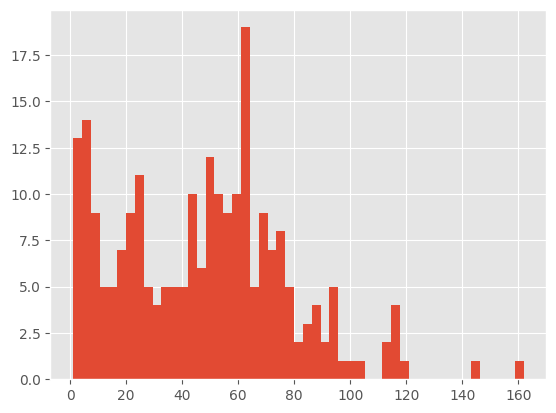

In [26]:
# Verify connectivity
print(f"Is the graph fully connected: {nx.is_connected(G)}\n")

# Network statistics
print(f"Number of nodes: \t{G.nodes().__len__()}")
print(f"Number of edges: \t{G.edges().__len__()}")
print(f"Network diameter: \t{nx.diameter(G)}")
print(f"Average shortest path: \t{nx.average_shortest_path_length(G):.4f}")

# Degree distribution
plt.hist(dict(G.degree()).values(), bins=51)
plt.show()

In [27]:
# Other statistics
clustering_coefficient  = nx.clustering(G)
degree_centrality       = nx.degree_centrality(G)
betweenness_centrality  = nx.betweenness_centrality(G)
closeness_centrality    = nx.closeness_centrality(G)
eigenvector_centrality  = nx.eigenvector_centrality(G)
density                 = nx.density(G)

## Visualize the FakeNewsNet PolitiFact graph

100%|██████████| 2/2 [00:00<?, ?it/s]


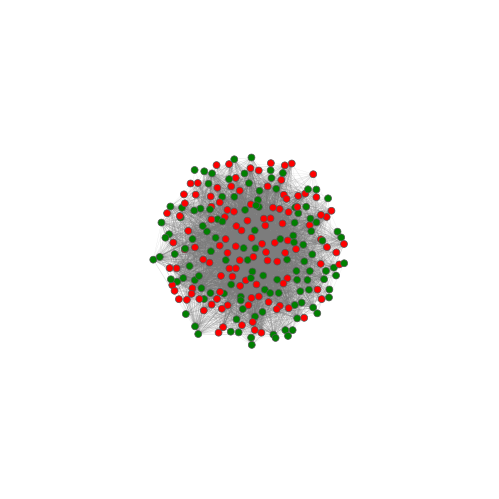

In [28]:
# Create ground truth partition
colors = ['green', 'red']
fakenews_partition = [{node for node in G.nodes() if target in node} for target in ['Real', 'Fake']]

# Retrieve color codes on the node level
viz_partition = {}
for i, partition_ in enumerate(tqdm(fakenews_partition)):
    for node_ in partition_:
        viz_partition[node_] = colors[i]

# Set color codes on the node level
nx.set_node_attributes(G, viz_partition, "group")

# Visualize network
stylized_network, config = nw.visualize(G)
fig, ax = nw.draw_netwulf(stylized_network)
plt.show()

### Clustering - Louvain method

In [29]:
# Apply Louvain method for detecting best partition of the graph
louvain_partition       = nx.community.louvain_communities(G)
modularity              = nx.community.modularity(G, louvain_partition)
print(modularity)

0.4929981614511675


100%|██████████| 6/6 [00:00<?, ?it/s]


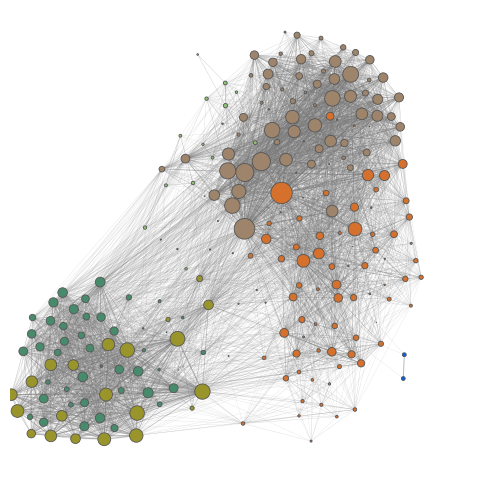

In [75]:
colors = [f"C{i}" for i in range(louvain_partition.__len__())]

# Retrieve color codes on the node level
viz_partition = {}
for i, partition_ in enumerate(tqdm(louvain_partition)):
    for node_ in partition_:
        viz_partition[node_] = colors[i]

# Set color codes on the node level
nx.set_node_attributes(G, viz_partition, "group")

# Visualize network
stylized_network, config = nw.visualize(G)
fig, ax = nw.draw_netwulf(stylized_network)
plt.show()

## Node2Vec

In [30]:
from pathlib import Path

import numpy as np
import networkx as nx
import netwulf as nw
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
pd.options.future.infer_string = True

# Set path to data folder
DATA_DIR = Path(r"C:\Users\alber\Desktop\DTU\3_HCAI\02807\project\02807_CompTools_Project\data")

In [31]:
with open(DATA_DIR / 'processed/FakeNewsNet/testIds.txt', 'r') as f:
    testIds = f.read().split('\n')

with open(DATA_DIR / 'processed/FakeNewsNet/trainIds.txt', 'r') as f:
    trainIds = f.read().split('\n')
    
full_weighted_edgelist = pd.read_csv(DATA_DIR / 'processed/FakeNewsNet/full_graph_weighted_edgelist.csv')

# Create networkx graph
G = nx.from_pandas_edgelist(full_weighted_edgelist, source='source', target='target', edge_attr='weight', create_using=nx.Graph)

## Node2Vec

https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef

In [88]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from node2vec import Node2Vec

# Generate walks
node2vec    = Node2Vec(G, dimensions=32, walk_length=10, num_walks=100)
model       = node2vec.fit(window=10, min_count=1)

# Get vector representations
train2vec       = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in trainIds}
test2vec        = {node_: model.wv.vectors[i] for i, node_ in enumerate(model.wv.index_to_key) if node_ in testIds}

Xtrain, Xtest   = np.array(list(train2vec.values())), np.array(list(test2vec.values()))
ytrain          = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in trainIds]) 
ytest           = np.array(['fake' if 'fake' in node_.lower() else 'real' for node_ in model.wv.index_to_key if node_ in testIds])

ytrain          = (ytrain == 'real').astype(int)
ytest           = (ytest == 'real').astype(int)

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


### Examine global vs. local modeling

In [128]:
from sklearn.cluster import KMeans

np.random.seed(0)

K = 4

cls             = KMeans(n_clusters=K, random_state=0, n_init=100)
kmeans_train    = cls.fit_predict(Xtrain)
kmeans_test     = cls.predict(Xtest)

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Fit global classifier
clf_global          = RandomForestClassifier(n_estimators=100, random_state=42)
clf_global.fit(Xtrain, ytrain)

# Fit cluster classifiers
clf_local = {}
for k in tqdm(range(K)):
    clf_cluster_    = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_cluster_.fit(Xtrain[kmeans_train == k], ytrain[kmeans_train == k])
    clf_local[k]    = clf_cluster_ 

100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


In [130]:
global_preds    = clf_global.predict(Xtest)
print(f"Accuracy for global classifier: {np.mean(global_preds == ytest):.4f}")

local_preds = np.ones(ytest.shape) * -1
for k in range(K):
    if (kmeans_test == k).sum() != 0:
        pred_cluster_   = clf_local[k].predict(Xtest[kmeans_test == k])
        local_preds[kmeans_test == k] = pred_cluster_
        print(f"Accuracy for cluster {k}: {np.mean(pred_cluster_ == ytest[kmeans_test == k]):.4f}")

print(f"Accuracy for local classifier: {np.mean(local_preds == ytest):.4f}")

Accuracy for global classifier: 0.9167
Accuracy for cluster 0: 1.0000
Accuracy for cluster 1: 0.9091
Accuracy for cluster 2: 1.0000
Accuracy for local classifier: 0.9583


In [151]:
from collections import Counter

# Get baseline as majority voter
uniques, counts = np.unique(ytrain, return_counts=True)
majority_voter  = uniques[np.argmax(counts)]
baseline_preds  = majority_voter * np.ones(ytest.shape)

In [221]:
# add silhoutte score, davies bouldin index, within-cluster sum of squares, modularity, rand index, adjusted rand index, normalized mutual information, weighted f1 score, precision, recall, accuracy, confusion matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, f1_score, precision_score, recall_score, confusion_matrix

results = {}
for type_, ypred in [('baseline', baseline_preds), ('global', global_preds), ('local', local_preds), ('kmeans', kmeans_test)]:
    results[type_] = {}

    results[type_]['SS']               = silhouette_score(Xtest, ypred) if type_ != 'baseline' else None
    results[type_]['DBI']          = davies_bouldin_score(Xtest, ypred) if type_ != 'baseline' else None
    results[type_]['CHS']       = calinski_harabasz_score(Xtest, ypred) if type_ != 'baseline' else None
    results[type_]['ARI']           = adjusted_rand_score(ytest, ypred)
    results[type_]['NMI'] = normalized_mutual_info_score(ytest, ypred)
    results[type_]['accuracy']                      = np.mean(ytest == ypred)
    results[type_]['weighted_f1_score']             = f1_score(ytest, ypred, average='weighted')
    results[type_]['precision']                     = precision_score(ytest, ypred, average='weighted', zero_division=0.0)
    results[type_]['recall']                        = recall_score(ytest, ypred, average='weighted', zero_division=1.0)

results     = pd.DataFrame(results)

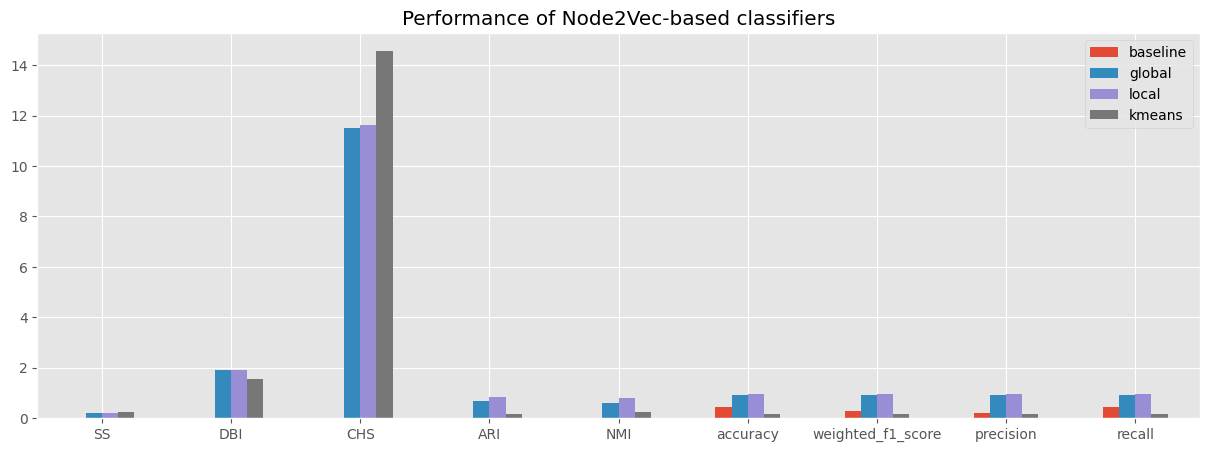

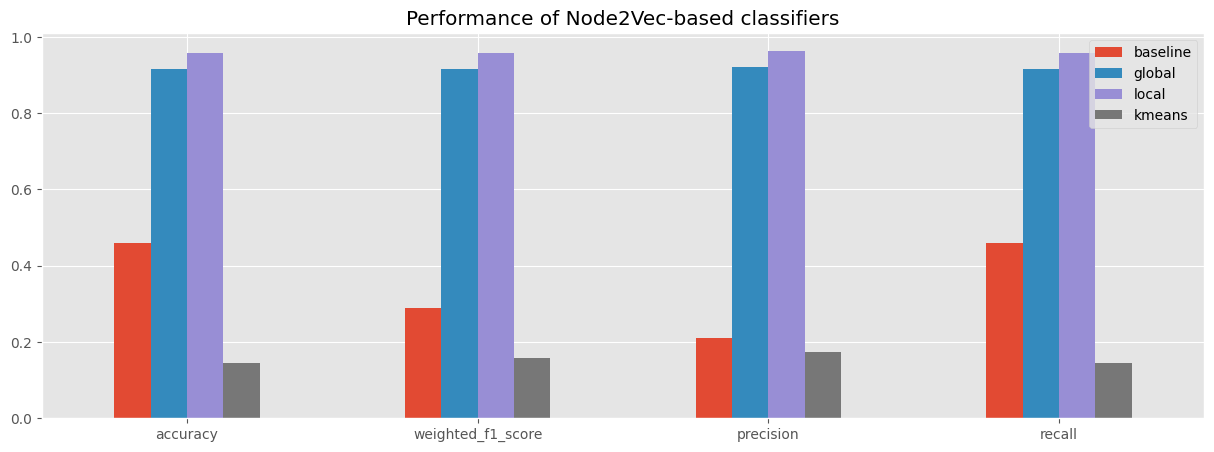

In [223]:
results.plot(kind='bar', figsize=(15, 5), rot=0, title='Performance of Node2Vec-based classifiers')
plt.legend(loc='upper right')
plt.show()

results.T[['accuracy', 'weighted_f1_score', 'precision', 'recall']].T.plot(kind='bar', figsize=(15, 5), rot=0, title='Performance of Node2Vec-based classifiers', legend=True)
plt.legend(loc='upper right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


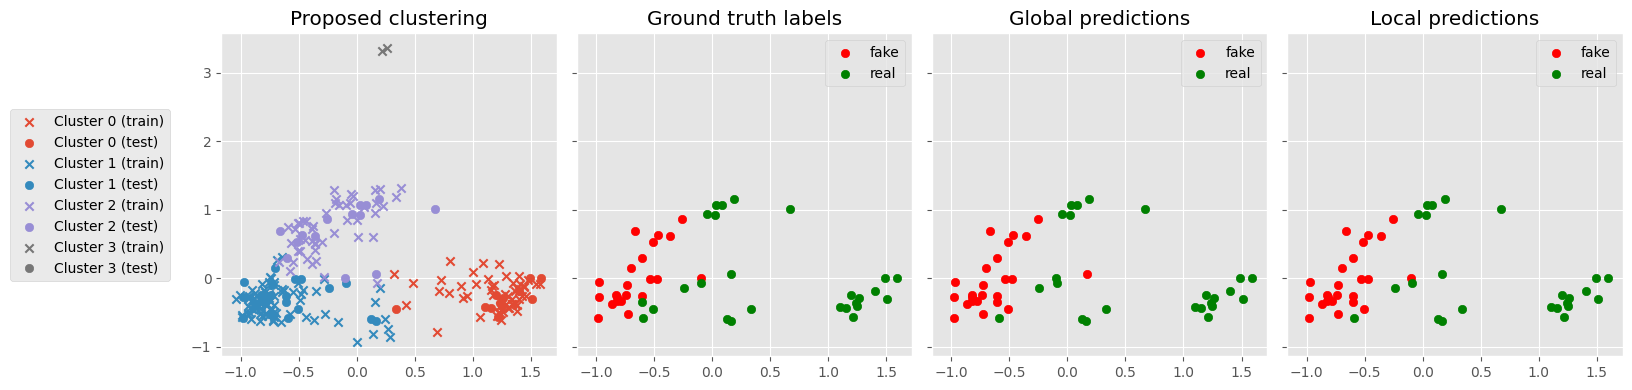

In [224]:
# Run PCA projection
pca             = PCA(n_components=2, random_state=42)
pca_proj        = pca.fit_transform(Xtrain)
pca_proj_test   = pca.transform(Xtest)

# Do a visualization with scatter plot from PCA that is colored by the cluster labels
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True, sharex=True, squeeze=False)
for k in range(K):
    axs[0, 0].scatter(pca_proj[kmeans_train == k, 0], pca_proj[kmeans_train == k, 1], color=f'C{k}', label=f'Cluster {k} (train)', marker='x')
    axs[0, 0].scatter(pca_proj_test[kmeans_test == k, 0], pca_proj_test[kmeans_test == k, 1], color=f'C{k}', label=f'Cluster {k} (test)', marker='o')

axs[0, 0].set_title('Proposed clustering')
axs[0, 0].legend(loc='center left', bbox_to_anchor=(-0.65, 0.5))

for label in [0, 1]: # [fake, real]
    axs[0, 1].scatter(pca_proj_test[ytest == label, 0], pca_proj_test[ytest == label, 1], label='fake' if label == 0 else 'real', color='red' if label == 0 else 'green')
    axs[0, 2].scatter(pca_proj_test[global_preds == label, 0], pca_proj_test[global_preds == label, 1], label='fake' if label == 0 else 'real', color='red' if label == 0 else 'green')
    axs[0, 3].scatter(pca_proj_test[local_preds == label, 0], pca_proj_test[local_preds == label, 1], label='fake' if label == 0 else 'real', color='red' if label == 0 else 'green')

axs[0, 1].set_title('Ground truth labels')
axs[0, 2].set_title('Global predictions')
axs[0, 3].set_title('Local predictions')

axs[0, 1].legend(loc='upper right')
axs[0, 2].legend(loc='upper right')
axs[0, 3].legend(loc='upper right')

ax.legend()
plt.tight_layout()
plt.show()


## Spectral Clustering


### Classifying based on "eigenfeatures"